In [1]:
import numpy as np

from scipy import constants, optimize
from matplotlib import pyplot as plt

import optical_modulation as omod

from light_source import LightSource
from optical_fiber import OpticalFiber
from photodetector import Photodector
from backscattering import backscatterer

In [2]:
figfolder = "../../figures/"

In [3]:
central_frequency = 194e12                                                         # 194 THz
frequency_linewidth = 3e3                                                          # 3 KHz

source = LightSource(
        frequency=central_frequency,
        frequency_linewidth=frequency_linewidth,
        power=1e-3,                                                                 # 1 mW = 0 dBm
        frequency_step=250,                                                         # 250 Hz
        bandwidth=8 * frequency_linewidth,
        shape="lorentzian",
    )

fiber = OpticalFiber(
    refractive_index=1.44,
    refractive_index_variation=1e-7,
    attenuation_coefficient=0.2,  # 0.2 dB / km
    segment_size=1e-2,  # 1 cm
    segment_size_variation=5,  # 5 %
    mode_field_diameter=2.13,
    average_backscattering_field_coefficient=70,
    length=1e3,  # 1 km
)

detector = Photodector(responsitivity=1,    # Ideal
                       bandwidth=100e6        # 100 MHz
)

In [4]:
pulse_width = 10e-9        # 1 ns
segment_duration = 1e-11
rise_time = pulse_width / 10

time = omod.get_pulse_time_array(pulse_width, segment_duration, rise_time)
sine_pulse = omod.get_sine_rectangular_pulse(pulse_width, time, rise_time)

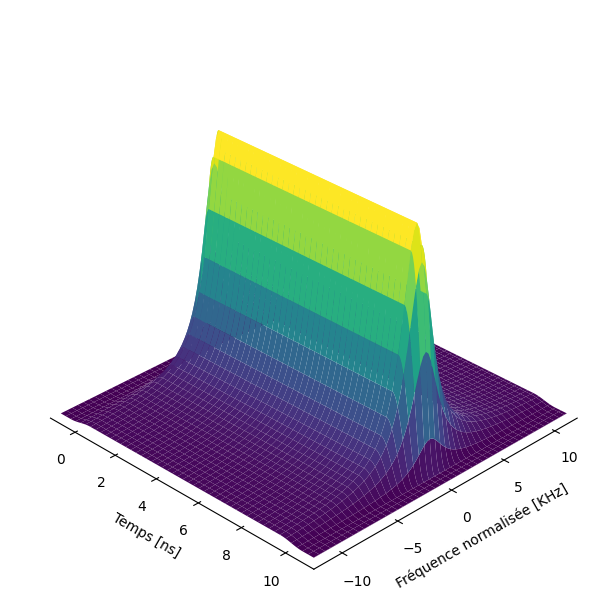

In [5]:
distribution = np.outer(source.normalized_lineshape, sine_pulse)
TIME, FREQ = np.meshgrid(time, source.frequencies, )

fig = plt.figure(figsize=(8, 6), layout="constrained")
ax = fig.add_subplot(111, projection='3d')

TIME *= 1e9
FREQ = (FREQ - source.frequency) / 1e3

ax.plot_surface(TIME, FREQ, distribution, cmap='viridis', linewidth=0)

ax.set_xlabel("Temps [ns]")
ax.set_ylabel("Fréquence normalisée [KHz]")
ax.set_xlim(TIME.min(), TIME.max())
ax.set_ylim(FREQ.min(), FREQ.max())

ax.set_facecolor('white')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_visible(False)
ax.zaxis.set_visible(False)
ax.zaxis.set(ticks=[])
ax.grid(visible=False)
ax.view_init(elev=30, azim=-45, roll=0)

plt.savefig(figfolder + "time_frequency_distribution.pdf")
plt.show()

In [6]:
time = omod.get_pulse_time_array(pulse_width, fiber.segment_duration, rise_time)
sine_pulse = omod.get_sine_rectangular_pulse(pulse_width, time, rise_time)

In [7]:
signal = detector.detect(backscatterer(source, fiber, sine_pulse), fiber.segment_duration, source.normalized_lineshape)
z = detector.crop_to_bandwidth(fiber.segment_locations, fiber.segment_duration)

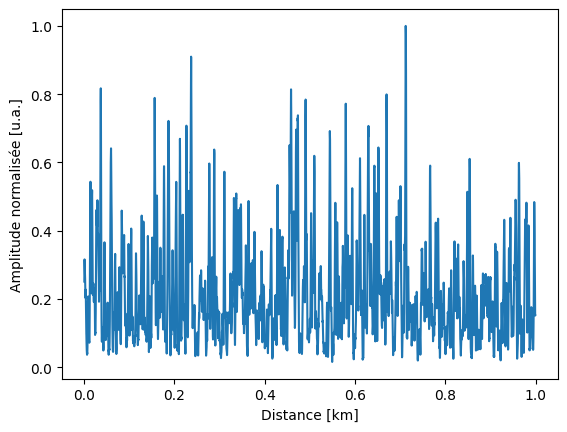

In [8]:
plt.plot(z * 1e-3, signal / signal.max())
plt.xlabel("Distance [km]")
plt.ylabel("Amplitude normalisée [u.a.]")
plt.savefig(figfolder + "initial_trace_1km.pdf")
plt.show()

In [9]:
from copy import deepcopy

new_fiber = OpticalFiber(
    refractive_index=1.44,
    refractive_index_variation=1e-7,
    attenuation_coefficient=0.2,  # 0.2 dB / km
    segment_size=1e-2,  # 1 cm
    segment_size_variation=5,  # 5 %
    mode_field_diameter=2.13,
    average_backscattering_field_coefficient=70,
    length=20e3, 
)

time = omod.get_pulse_time_array(pulse_width, new_fiber.segment_duration, rise_time)
sine_pulse = omod.get_sine_rectangular_pulse(pulse_width, time, rise_time)

long_signal = detector.detect(backscatterer(source, new_fiber, sine_pulse), new_fiber.segment_duration, source.normalized_lineshape)
long_z = detector.crop_to_bandwidth(new_fiber.segment_locations, new_fiber.segment_duration)

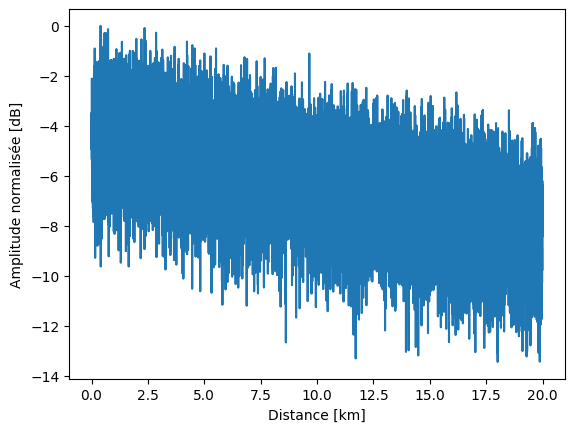

In [21]:
plt.plot(long_z * 1e-3, 5*np.log10(long_signal / long_signal.max()))
plt.xlabel("Distance [km]")
plt.ylabel("Amplitude normalisée [dB]")
plt.savefig(figfolder + "initial_trace_20km.pdf")
plt.show()

On étudie maintenant l'impact de différent paramètres. À chaque fois, la trace est normalisée par sa perte de référence. La même fibre est utilsée pour chaque simulation.

In [11]:
# Evaluate impact of pulse

pulse_widths = np.linspace(0.01e-9, 20e-9, 20)
signals = []

for pw in pulse_widths:
    rise_time = pw / 10

    time = omod.get_pulse_time_array(pw, fiber.segment_duration, rise_time)
    new_sine_pulse = omod.get_sine_rectangular_pulse(pw, time, rise_time)

    signal = detector.detect(backscatterer(source, fiber, new_sine_pulse), fiber.segment_duration, source.normalized_lineshape)
    signals.append(signal)

In [12]:
signals = np.array(signals)
signals /= signals.max()

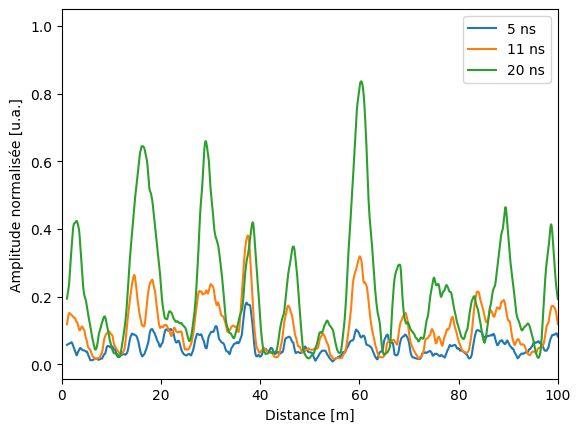

In [13]:
for i in 5, 10, 19:
    plt.plot(z, signals[i], label=f"{pulse_widths[i]*1e9:.0f} ns")

plt.xlabel("Distance [m]")
plt.ylabel("Amplitude normalisée [u.a.]")
plt.xlim(0, 100)
plt.legend()

plt.savefig(figfolder + "trace@different_pulse.pdf")
plt.show()

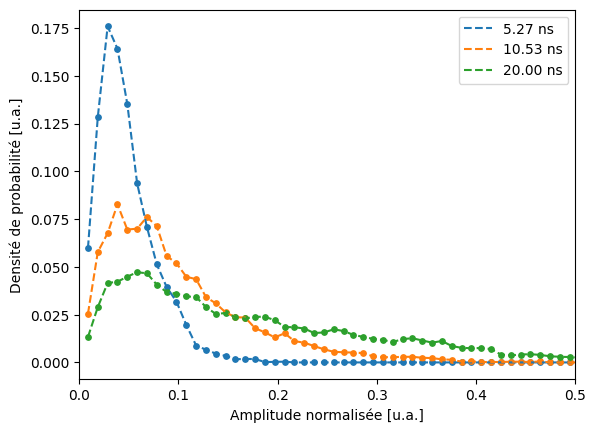

In [14]:
_, bins = np.histogram(signals[-1], bins=100)

for i in 5, 10, 19:
    heigts, bins = np.histogram(signals[i], bins=bins)
    plt.scatter(bins[:-1], heigts / heigts.sum(), s=15)
    plt.plot(bins[:-1], heigts / heigts.sum(), label=f"{pulse_widths[i]*1e9:.2f} ns", ls="--")

plt.ylabel("Densité de probabilité [u.a.]")
plt.xlabel("Amplitude normalisée [u.a.]")
plt.xlim(0, 0.5)
plt.legend()

plt.savefig(figfolder + "hist@different_pulse.pdf")
plt.show()

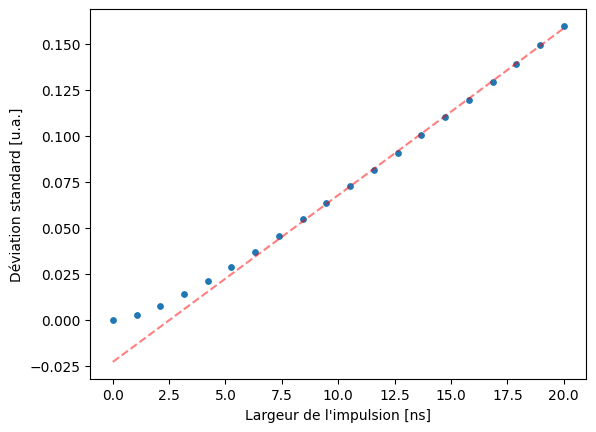

In [15]:
line = lambda x, a, b: a*x + b

stds = signals.std(axis=1)

popt, pcov = optimize.curve_fit(line, pulse_widths[8:], stds[8:])

plt.plot(pulse_widths * 1e9, line(pulse_widths, *popt), color="red", ls="--", alpha=0.5)
plt.scatter(pulse_widths * 1e9, stds, s=15)
plt.xlabel("Largeur de l'impulsion [ns]")
plt.ylabel("Déviation standard [u.a.]")
plt.savefig(figfolder + "different_pulse.pdf")
plt.show()

In [16]:
# Evaluate impact of pulse

linewidths = np.linspace(0.5e3, 5e3, 10)
signals_lw = []

for lw in linewidths:
    new_source = deepcopy(source) 
    new_source.frequency_linewidth = lw

    signal = detector.detect(backscatterer(new_source, fiber, sine_pulse), fiber.segment_duration, new_source.normalized_lineshape)
    signals_lw.append(signal)

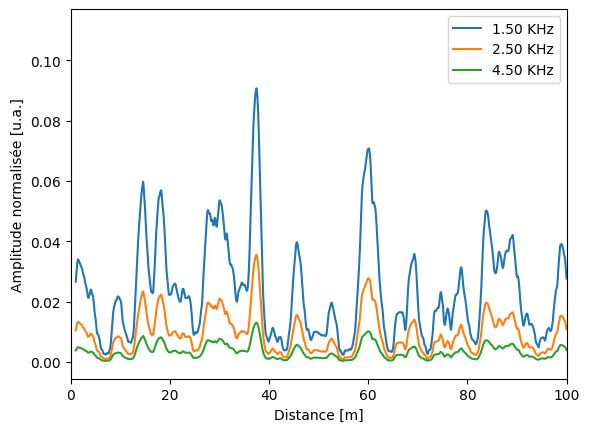

In [17]:
signals_lw = np.array(signals_lw)
signals_lw /= signals_lw.max()
signals_lw_corrected = signals_lw - signals_lw.min(axis=1)[:,None]

for i in 2, 4, 8:
    plt.plot(z, signals_lw_corrected[i], label=f"{linewidths[i]*1e-3:.2f} KHz")

plt.xlabel("Distance [m]")
plt.xlim(0, 100)
plt.ylabel("Amplitude normalisée [u.a.]")
plt.legend()


plt.savefig(figfolder + "trace@different_linewidth.pdf")
plt.show()

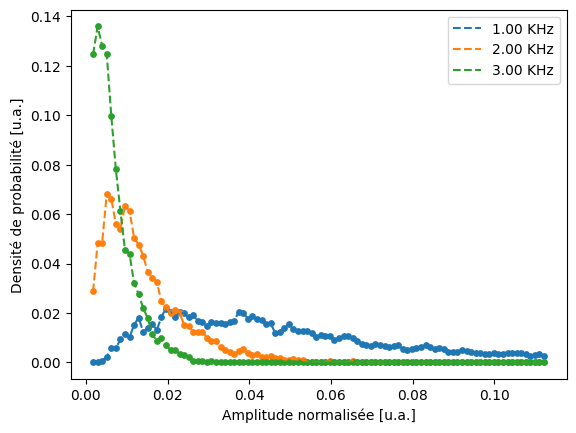

In [18]:
_, bins = np.histogram(signals_lw[2], bins=100)

for i in 1, 3, 5:
    heigts, bins = np.histogram(signals_lw[i], bins=bins)
    plt.scatter(bins[:-1], heigts / heigts.sum(), s=15)
    plt.plot(bins[:-1], heigts / heigts.sum(), label=f"{linewidths[i]*1e-3:.2f} KHz", ls="--")

plt.ylabel("Densité de probabilité [u.a.]")
plt.xlabel("Amplitude normalisée [u.a.]")
plt.legend()

plt.savefig(figfolder + "hist@different_linewidth.pdf")
plt.show()

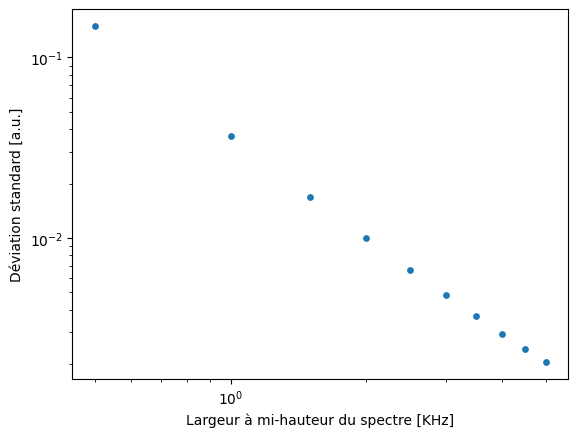

In [20]:
plt.scatter(linewidths * 1e-3, signals_lw_corrected.std(axis=1), s=15)
plt.xlabel("Largeur à mi-hauteur du spectre [KHz]")
plt.ylabel("Déviation standard [a.u.]")
plt.yscale("log")
plt.xscale("log")
plt.savefig(figfolder + "linewidth.pdf")
plt.show()